# Module 2, Notebook 1: BraTS Data Processing

https://colab.research.google.com/github/julclu/CSC509/blob/main/Module2/Module2_NB1_BraTS_DataProcessing.ipynb


# Objectives 
1. Setting up the env
2. Data bookkeeping
3. Loading data 
4. Investigating data 

# 1. Setting up the environment

Recall the previous lecture on how to mount a google drive and set up a shortcut to the dataset. 

In [ ]:
import numpy as np
import os
from pathlib import Path
import glob
import pandas as pd
import math

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

# 2. Data "bookkeeping" 
Objectives: 
* What data do we have? 
* In what format? 

In [ ]:
os.listdir(Path('/content/drive/MyDrive/Data_Shortcut/Module2_BraTS/'))

In [ ]:
DATA_PATH = Path('/content/drive/MyDrive/Data_Shortcut/Module2_BraTS/MICCAI_BraTS2020_TrainingData')

List the training data in the data path and read in the csv files: 

In [ ]:
train_patients = [x for x in os.listdir(DATA_PATH) if '.csv' not in x]
print(f'There are {len(train_patients)} patients in the training folder')

In [ ]:
valid_patients = [x for x in os.listdir(Path(DATA_PATH.parent, 'MICCAI_BraTS2020_ValidationData')) if '.csv' not in x]
print(f'There are {len(valid_patients)} patients in the validation folder')

Now list only the CSV files that are available and read them in accordingly: 

In [ ]:
glob.glob(str(Path(DATA_PATH, '*.csv')))

In [ ]:
name_mapping_df = pd.read_csv(Path(DATA_PATH, 'name_mapping.csv'))
survival_info_df = pd.read_csv(Path(DATA_PATH, 'survival_info.csv'))

Explore the data frames below to see what they contain: 

In [ ]:
name_mapping_df.head()

Looks like the name mapping data frame allows you to map between older versions of the BraTS dataset, the TCGA/TCIA dataset (if you wanted to look at genetic information), and tells you whether the patient was considered a high-grade glioma, or a low-grade glioma (these are outdated groupings, but for now they are ok). 


In [ ]:
name_mapping_df.Grade.value_counts()

In [ ]:
survival_info_df.head()

Survival and other demographic information is contained in the survival information data frame. This might be useful if you wanted to use the images to predict an alternative endpoint instead of segmentation, for example. 

Now that we know what our tabular information is in this dataset, we should take a look at what the imaging data looks like. First, let's just take a look at the format of the imaging files from one of the patients: 

In [ ]:
os.listdir(DATA_PATH)[:10]

In [ ]:
os.listdir(Path(DATA_PATH, 'BraTS20_Training_001'))

# 3. Loading data 
 
* How to load the data using python packages
* How to visualize the data

Looks like these have the extension ".nii.gz", which is a common neuroimaging file format (that you may or may not have encountered in this course yet!) called "NIFTI", which actually stands for the "Neuroimaging Informatics Technology Initiative." In order to read NIFTI files using python, we need to use a specific package. Nibabel is a common one, so let's load that now: 

In [ ]:
import nibabel as nib # The NIFTI reader 
import matplotlib.pyplot as plt # The visualizer

Nibabel has a `nib.load` function that will load NIFTI files with ease; now we just have to load and look at all of the following choices from this patient:  
* t1
* t1ce
* t2 
* flair 
* seg

<br> Each of these refers to the MRI scan type that was used to acquire the particular image, which will have unique image contrast when compared to one another. This should have been covered a bit in Module 0 or reviewed in your Module 2 lectures. Let's start by reading them in and visualizing them, starting with a t1 from patient 001: 


In [ ]:
t1_001 = nib.load(Path(DATA_PATH, f'BraTS20_Training_001', f'BraTS20_Training_001_t1.nii.gz'))

In [ ]:
# To get the image part of the nifti file format, you have to look at the ._dataobj part of the class, or use .get_fdata() function. 
t1_img = t1_001.get_fdata()
# Let's get the dimensions of the image 
t1_img.shape


In [ ]:
# To look at the file halfway through, use .shape[-1] to get the last dimension (155), and divide by 2 (rounding using //)
plt.imshow(t1_img[:,:,t1_img.shape[-1]//2], cmap = 'gray')

We are lucky - this data is really well curated and well named. We notice that there is an easy pattern to reading in the data from the file system, where the path is the same for each patient except for the patient ID and the type of image. Because of this, we can write a quick function to read in all the images from any patient into a dictionary, which will be easier to keep track of:  

In [ ]:
def read_patient_niftis(patient_id: str, 
                        niftis_to_load = ['t1', 't1ce', 't2', 'flair', 'seg'], 
                        data_path = DATA_PATH):
    """
    Will read in the images from a single patient and return a dictionary of 
    those images with the key as the image type and the value as the nifti object. 
    patient_id: string of format '001' through '369', patient ID in BRATS
    niftis_to_load: default is list containing all the types of images that we care about; can sub in another list if desired. 
    data_path: default is DATA_PATH specified above with respect to the mounted google drive (in colab)

    """
    patient_image_dict = {}
    for image in niftis_to_load: 
        patient_image_dict[image]=nib.load(Path(DATA_PATH, f'BraTS20_Training_{patient_id}', f'BraTS20_Training_{patient_id}_{image}.nii.gz'))
    return patient_image_dict
  

In [ ]:
## Reading in the first patient, 001, into a dictionary: 
pt_img_dict = read_patient_niftis('001')

In [ ]:
## Looking at the dimensions of the files. Are they all the same? 
print(pt_img_dict['t1'].shape)
print(pt_img_dict['t1ce'].shape)
print(pt_img_dict['t2'].shape)
print(pt_img_dict['flair'].shape)
print(pt_img_dict['seg'].shape)

What does a single slice of this volume look like? 

In [ ]:
# Make sure the t1 is the same as before and we wrote our function correctly: 
t1_img = pt_img_dict['t1'].get_fdata()
plt.imshow(t1_img[:,:,t1_img.shape[-1]//2], cmap = 'gray')

In [ ]:
# Let's look at all of the types of images in the patient 001 dictionary by iterating through the dictionary

plt.figure(figsize=(15,10)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()): # iterates through the dictionary, while the enumerate function keeps track of the index with i
    plt.subplot(1,5,i+1)    # the number of images in the grid 
    plt.imshow(value._dataobj[:, :, value.shape[-1]//2].T, cmap='gray') # Looks halfway through the volume and transposes the image so that its facing upward. 
    plt.axis('off')
    plt.title(key)
plt.show()

# 4. Investigating the data
 
* What do each of these MRI data types show with respect to brain tumors? 
* Noticing patterns and differences between and among the MR images of brain tumors

It would be helpful to visualize multiple patients at a time to get a better sense of what these values look like. Here, we're writing a function in order to visualize multiple patients at a time: 

In [ ]:

def visualize_nifti_volume(patient_image_dict: dict, scan_type:str='t1', visualize_every:int=1): 
    """
    Takes a patient_image_dict from 
    dicom_volume,  e.g. {'1': <pixel_data>, ...}
    output is to plot an appropriate size image of the voulme that one is interested in. 
    """
    nifti_vol = patient_image_dict[scan_type].get_fdata()
    num_rows = math.ceil(nifti_vol.shape[2]/visualize_every/5)
    keys_sorted = range(0, nifti_vol.shape[2], visualize_every)
    plt.figure(figsize = (20, 15*num_rows))
    for i in keys_sorted: # iterates through the dictionary, while the enumerate function keeps track of the index with i
        plt.subplot(5*num_rows,5,(i)//visualize_every+1)    # the number of images in the grid 
        value = nifti_vol[:,:,i].T
        plt.imshow(value, cmap= 'gray')
        plt.axis('off')
        plt.title(i)
    plt.show()

In [ ]:

visualize_nifti_volume(patient_image_dict = pt_img_dict, scan_type='t1', visualize_every = 2)

In [ ]:
def visualize_multiple_patients(patient_list: list): 
  """
  Takes a patient list of patient_ids (strings) and visualizes them, gives them the proper titles. 
  patient_list e.g. ['001', '002']
  output is to plot an appropriate size image of the patients that one is interested in. 
  """
    num_rows = len(patient_list)
    for idx, patient in enumerate(patient_list): 
        plt.figure(figsize = (20, 5*num_rows))
        pt_img_dict = read_patient_niftis(patient)
    for i, (key, value) in enumerate(pt_img_dict.items()): 
        plt.subplot(num_rows, 5, i+1)
        img = value.get_fdata()
        plt.imshow(img[:, :, img.shape[-1]//2].T, cmap='gray')
        plt.axis('off')
        plt.title("ID: "+patient+", "+key)
    plt.show()



In [ ]:
visualize_multiple_patients(['001', '002', '003'])

So let's take a second to notice some patterns here. What do you notice? Here are some questions to help you think about it: 
1. **Are there any general patterns with brightness/contrast that you can see that some image types have? (1 pt)**
2. **Is any image type clearly giving us different information than another? (1 pt)** 
3. **How many parts of the segmentation are there?** 
4. **What might the relationship be between T2 and FLAIR?** 
5. **Is there a relationship between T1 and T1C?**

Since there are often different ranges of intensity values in the images, let's look at the range of intensities in each of patient 001's images: 

In [ ]:
plt.figure(figsize=(25,5)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()): # iterates through the dictionary, while the enumerate function keeps track of the index with i
    plt.subplot(1,5,i+1)    # the number of images in the grid 
    img = value.get_fdata()
    plt.hist(img.flatten())
    plt.title(key)
plt.show()

Because there are so many 0s, it's tough to look at the dynamic range of the intensity values. Let's just visualize the plots without the 0s. 

In [ ]:
plt.figure(figsize=(25,5)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()): 
    plt.subplot(1,5,i+1)   
    img = value.get_fdata()
    plt.hist(img.flatten()[img.flatten()!=0])
    # plt.xlim(0, 2000)
    plt.title(key)
plt.show()

If you want to see them all on the same scale: 

In [ ]:
plt.figure(figsize=(25,5)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()): 
    plt.subplot(1,5,i+1)   
    img = value.get_fdata()
    plt.hist(img.flatten()[img.flatten()!=0])
    plt.ylim(0, 75000)
    plt.title(key)
plt.show()

The range of the MRI pixel values is called the "dynamic range". We can see that it's different for each type of image. Specifically: 
* T1's maximum: 700
* T1CE's maximum: 1750 
* T2's maximum: 300 
* FLAIR's maximum: 600 
* SEG's maximum: 4 

**QUESTION: Can you think of why it might be an issue for a deep learner to deal with so many dynamic ranges if we read these in raw? (1 pt)** 

**QUESTION: How might we be able to solve that issue? (1 pt)** 

The segmentation is a special case, because there are 3 different segments in there. Let's look at those a little more closely. 

In [ ]:
## I cycled through a few of the slices to find one (71) that shows the 3 different tumor segments. 
slice_number = 71
plt.figure(figsize=(15,5)) # specifying the overall grid size
for i, img_type in enumerate(['seg', 't1ce', 'flair']): 
  plt.subplot(1, 3,i+1)
  img = pt_img_dict[img_type].get_fdata()
  plt.imshow(img[:,:,slice_number].T)
  plt.axis('off')
plt.show()

In [ ]:
## We saw from the histogram that the values are either 0, 1, 2, or 4. 
## Look at what each of these represent 
slice_number = 71
plt.figure(figsize=(15,5)) # specifying the overall grid size
for i, img_type in enumerate(['seg', 'seg', 'seg']): 
  plt.subplot(1, 3,i+1)
  img = pt_img_dict[img_type].get_fdata()
  if i <2: 
    plt.imshow(img[:,:,slice_number].T == i+1)
    plt.axis('off')
    plt.title(str(i+1))
  else: 
    plt.imshow(img[:,:,slice_number].T == 4)
    plt.axis('off')
    plt.title('4')
plt.show()

From the previous two cells, we can conclude which segmentation each of the 1s, 2s, and 4s represent. Refer back to your lecture materials and answer the following questions: 
1. **What are the names of each of these regions? (1 pt)**
2. **Which number corresponds to which region?  (1 pt)**

# 5. Play around and explore. 

1. Pick the patients with the longest and shortest survival and look at their tumors. 
2. Do you notice any difference? 

# 6. Why is the data so perfect? 

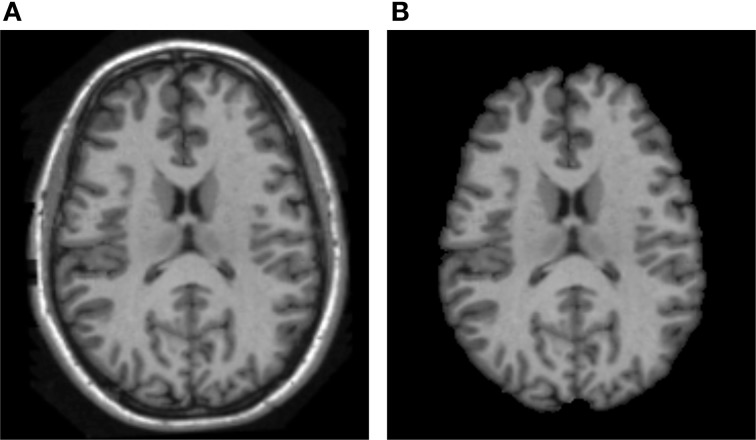

You might notice that all our data looks like (B), but in fact it originally was like (A). 

* (A) contains the skull - (B) has gone through a process called skull stripping. 
* In fact, the data we are working with has gone through a LOT of preprocessing. What does that look like? 

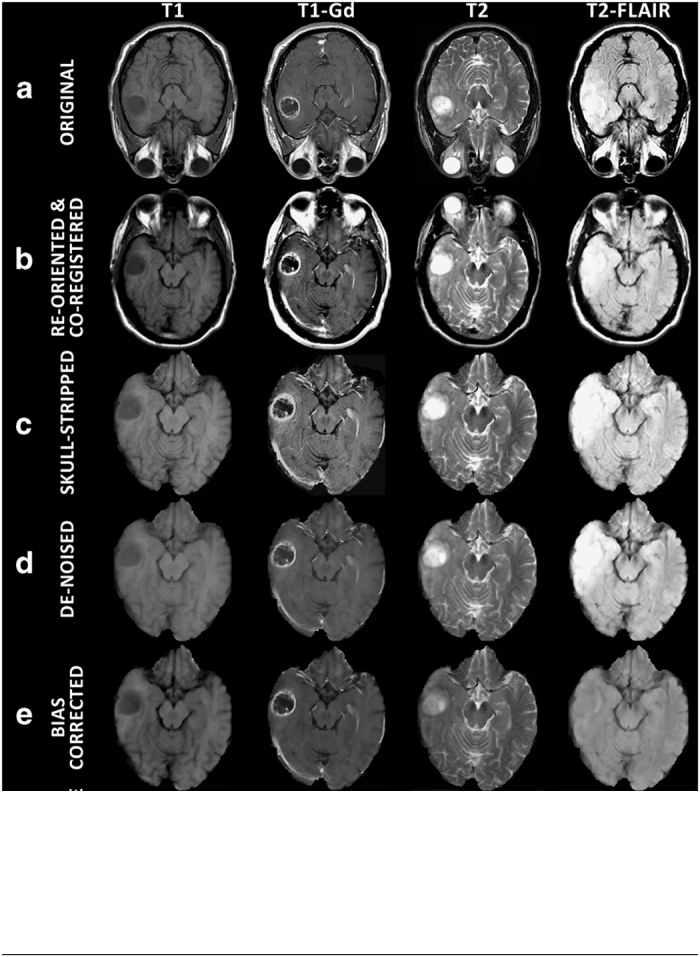

Looking at the above processing steps - let's be thankful that we don't have to do all that ourselves! 
1. **Can you describe the visual differences between each step? (1 pt)**
2. **Why do you think each step might be important?  (1 pt)**